# Variability

Investigate the differences in transcriptome variability between drugs that target the same system

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import scipy.stats as stats

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data_path = '/data_volume/memento/sciplex/'

In [5]:
ct = 'A549'

In [6]:
adata = sc.read(data_path + 'h5ad/{}_HDAC.h5ad'.format(ct))

### Setup memento

In [7]:
adata.obs['q'] = 0.05

In [8]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:68: RankWarning: Polyfit may be poorly conditioned


### One sample test

In [9]:
subset = adata[(adata.obs.target == 'HDAC') & (adata.obs.dose == 10000)].copy().copy()

memento.create_groups(subset, label_columns=['product_name'])
memento.compute_1d_moments(subset, min_perc_group=.9)
memento.ht_1d_moments(
    subset, 
    formula_like='1',
    cov_column='Inter', 
    num_boot=10000, 
    verbose=1,
    num_cpus=90)

# subset.write(data_path + 'hdac/{}_vs_vehicle.h5ad'.format(drug))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
[Parallel(n_jobs=90)]: Using backend LokyBackend with 90 concurrent workers.
[Parallel(n_jobs=90)]: Done  20 tasks      | elapsed:    4.6s
[Parallel(n_jobs=90)]: Done 270 tasks      | elapsed:    7.9s
[Parallel(n_jobs=90)]: Done 620 tasks      | elapsed:   12.6s
[Parallel(n_jobs=90)]: Done 1070 tasks      | elapsed:   18.6s
[Parallel(n_jobs=90)]: Done 1620 tasks      | elapsed:   26.1s
[Parallel(n_jobs=90)]: Done 2326 out of 2326 | elapsed:   38.2s finished


In [10]:
df = memento.get_1d_ht_result(subset)
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])

### GSEA

In [25]:
import gseapy as gp
from gseapy.plot import gseaplot


In [26]:
pre_res = gp.prerank(
    rnk=df[['gene','dv_coef']].sort_values('dv_coef'), 
    gene_sets='GO_Biological_Process_2018',
    processes=14,
    permutation_num=100, # reduce number to speed up testing
    outdir=None, seed=6)

### Compare different HDACs to vehicle

In [39]:
for drug in adata.obs.product_name.drop_duplicates():
    
    if drug == 'Vehicle':
        continue

    subset = adata[(adata.obs.dose == 10000)].copy().copy()
    subset.obs['is_drug'] = (subset.obs.product_name==drug).astype(int)
    
    memento.create_groups(subset, label_columns=['is_drug', 'product_name'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + is_drug',
        cov_column='is_drug', 
        num_boot=10000, 
        verbose=1,
        num_cpus=70)
    
#     subset.write(data_path + 'hdac/{}_vs_rest.h5ad'.format(drug))
    
    break

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.4s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    5.1s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:   10.0s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   16.3s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   23.9s
[Parallel(n_jobs=70)]: Done 2326 out of 2326 | elapsed:   36.7s finished


In [40]:
df = memento.get_1d_ht_result(subset)
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])

In [42]:
df.query('dv_fdr < 0.1')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr,de_fdr
725,TTC1,0.0,0.0,0.0001,0.0,0.0,0.0001,0.077526,0.001278
860,RBM25,0.0,0.0,0.0001,0.0,0.0,0.0001,0.077526,0.001278
2069,GTF2F2,0.0,0.0,0.0001,0.0,0.0,0.0001,0.077526,0.001278


In [36]:
drug

'Divalproex Sodium'

In [57]:
heatmap = []
for drug in adata.obs.product_name.drop_duplicates():
    
    if drug == 'Vehicle':
        continue
        
    subset = sc.read(data_path + 'hdac/{}_vs_vehicle.h5ad'.format(drug))
    df = memento.get_1d_ht_result(subset)
    df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
    df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
    heatmap.append((drug, df.query('dv_fdr < 0.1& dv_coef < 0').shape[0], df.query('dv_fdr < 0.1 & dv_coef > 0').shape[0]))
    print(drug, df.query('de_fdr < 0.1').shape[0],df.query('dv_fdr < 0.1& dv_coef < 0').shape[0], df.query('dv_fdr < 0.1 & dv_coef > 0').shape[0])

Divalproex Sodium 1290 2 0
Abexinostat (PCI-24781) 1921 8 0
Sodium Phenylbutyrate 565 0 0
Tucidinostat (Chidamide) 1414 2 0
PCI-34051 1317 2 2
Resminostat 868 2 0
Panobinostat (LBH589) 1589 6 3
Quisinostat (JNJ-26481585) 2HCl 1798 22 16
MC1568 1107 1 0
Belinostat (PXD101) 1227 2 0
Dacinostat (LAQ824) 1708 8 8
Mocetinostat (MGCD0103) 1148 1 1
TMP195 1202 2 0
Droxinostat 215 0 0
M344 827 6 0
ITSA-1 (ITSA1) 1251 1 2
AR-42 1135 3 0
Tubastatin A HCl 632 7 0
Pracinostat (SB939) 1597 11 1
Tacedinaline (CI994) 625 14 0
Trichostatin A (TSA) 625 1 0
Entinostat (MS-275) 690 3 0
Givinostat (ITF2357) 1081 1 0


In [59]:
heatmap = pd.DataFrame(heatmap, columns=['gene', 'dv-', 'dv+'])

In [62]:
heatmap.index = heatmap.gene
heatmap = heatmap[['dv-', 'dv+']]

Text(0.5, 1.0, 'Drug vs control')

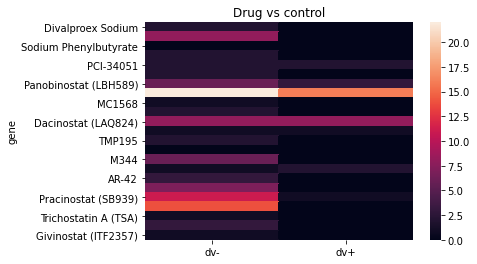

In [64]:
sns.heatmap(heatmap)
plt.title('Drug vs control')

### Drug-drug comparisons

Investigate if including the dosage changes anything

In [9]:
drug_counts = adata.obs.query('~vehicle').product_name.value_counts()
drug_list = drug_counts[drug_counts > 0].index.tolist()

In [10]:
drug_list = drug_counts[drug_counts > 0].index.tolist()
drug_list = [
    'Pracinostat (SB939)',
    'Quisinostat (JNJ-26481585) 2HCl',
    'Abexinostat (PCI-24781)',
    'Mocetinostat (MGCD0103)',
    'Divalproex Sodium',
    'M344',
    'Resminostat',
    'Panobinostat (LBH589)'
]

In [11]:
len(list(itertools.combinations(drug_list,2)))

28

In [12]:
# for drug1, drug2 in itertools.combinations(drug_list,2):
    
#     print(drug1, drug2)

#     subset = adata[adata.obs.product_name.isin([drug1, drug2]) & (adata.obs.dose == 10000)].copy().copy()
#     subset.obs['is_drug1'] = (subset.obs.product_name==drug1).astype(int)
    
#     memento.create_groups(subset, label_columns=['is_drug1'])
#     memento.compute_1d_moments(subset, min_perc_group=.9)
#     memento.ht_1d_moments(
#         subset, 
#         formula_like='1 + is_drug1',
#         cov_column='is_drug1', 
#         num_boot=10000, 
#         verbose=0,
#         num_cpus=94)
    
#     subset.write(data_path + 'hdac/{}_vs_{}_10000.h5ad'.format(drug1, drug2))

In [12]:
for drug1, drug2 in itertools.combinations(drug_list,2):
    
    print(drug1, drug2)

    subset = adata[adata.obs.product_name.isin([drug1, drug2])].copy().copy()
    subset.obs['is_drug1'] = (subset.obs.product_name==drug1).astype(int)
    subset.obs['dose_level'] = 'dose_' + subset.obs['dose'].astype(str)
    
    memento.create_groups(subset, label_columns=['is_drug1', 'dose_level'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + is_drug1 + dose_level',
        cov_column='is_drug1', 
        num_boot=10000, 
        verbose=0,
        num_cpus=94)
    
    subset.write(data_path + 'hdac/{}_vs_{}_stratified.h5ad'.format(drug1, drug2))

Pracinostat (SB939) Quisinostat (JNJ-26481585) 2HCl


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Pracinostat (SB939) Abexinostat (PCI-24781)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Pracinostat (SB939) Mocetinostat (MGCD0103)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Pracinostat (SB939) Divalproex Sodium


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Pracinostat (SB939) M344


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Pracinostat (SB939) Resminostat


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Pracinostat (SB939) Panobinostat (LBH589)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Quisinostat (JNJ-26481585) 2HCl Abexinostat (PCI-24781)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Quisinostat (JNJ-26481585) 2HCl Mocetinostat (MGCD0103)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Quisinostat (JNJ-26481585) 2HCl Divalproex Sodium


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Quisinostat (JNJ-26481585) 2HCl M344


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Quisinostat (JNJ-26481585) 2HCl Resminostat


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Quisinostat (JNJ-26481585) 2HCl Panobinostat (LBH589)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Abexinostat (PCI-24781) Mocetinostat (MGCD0103)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Abexinostat (PCI-24781) Divalproex Sodium


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Abexinostat (PCI-24781) M344


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Abexinostat (PCI-24781) Resminostat


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Abexinostat (PCI-24781) Panobinostat (LBH589)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Mocetinostat (MGCD0103) Divalproex Sodium


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Mocetinostat (MGCD0103) M344


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Mocetinostat (MGCD0103) Resminostat


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Mocetinostat (MGCD0103) Panobinostat (LBH589)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Divalproex Sodium M344


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Divalproex Sodium Resminostat


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Divalproex Sodium Panobinostat (LBH589)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


M344 Resminostat


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


M344 Panobinostat (LBH589)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Resminostat Panobinostat (LBH589)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


### Combine P-values

In [13]:
dv_pvals = pd.DataFrame()
start = True
for drug1, drug2 in itertools.combinations(drug_list,2):
    
    subset = sc.read(data_path + 'hdac/{}_vs_{}_stratified.h5ad'.format(drug1, drug2))
    df = memento.get_1d_ht_result(subset)
    if start:
        
        dv_pvals['gene'] = df['gene']
        dv_pvals['{}_{}'.format(drug1, drug2)] = df['dv_pval']
        start = False
    else:
        dv_pvals = dv_pvals.merge(df[['gene', 'dv_pval']].rename(columns={'dv_pval':'{}_{}'.format(drug1, drug2)}), how='outer')
        
# dv_pvals = pd.DataFrame()
# start = True
# for drug1, drug2 in itertools.combinations(drug_list,2):
    
#     subset = sc.read(data_path + 'hdac/{}_vs_{}_10000.h5ad'.format(drug1, drug2))
#     df = memento.get_1d_ht_result(subset)
#     if start:
        
#         dv_pvals['gene'] = df['gene']
#         dv_pvals['{}_{}'.format(drug1, drug2)] = df['de_pval']
#         start = False
#     else:
#         dv_pvals = dv_pvals.merge(df[['gene', 'de_pval']].rename(columns={'de_pval':'{}_{}'.format(drug1, drug2)}), how='outer')

In [14]:
combined_pvals = []
for g in dv_pvals.gene:
    pvalues = dv_pvals.query('gene == "{}"'.format(g)).iloc[0, 1:].values.astype(float)
    chisq, pv = stats.combine_pvalues(pvalues[np.isfinite(pvalues)])
    combined_pvals.append((g, chisq, pv))

In [15]:
combined_pvals = pd.DataFrame(combined_pvals, columns=['gene', 'chisq', 'pv'])
combined_pvals['fdr'] = memento.util._fdrcorrect(combined_pvals['pv'])

In [16]:
g = 'IDI1;ACLY;INSIG1;DHCR24;FDFT1'.split(';')

### GSEA + Enrichr

IDI1;ACLY;INSIG1;DHCR24;FDFT1

In [17]:
# for gene in combined_pvals.query('fdr < 0.01').sort_values('fdr').gene:
#     print(gene)

In [18]:
import gseapy as gp
from gseapy.plot import gseaplot


In [19]:
# pre_res = gp.prerank(rnk=combined_pvals.sort_values('chisq', ascending=False)[['gene', 'chisq']], gene_sets='GO_Biological_Process_2021',
#                      processes=90,
#                      permutation_num=100, # reduce number to speed up testing
#                      outdir=None,seed=6)

In [20]:
# pre_res.res2d.sort_index().head(30)


In [31]:
enr = gp.enrichr(gene_list=combined_pvals.query('fdr < 0.01').sort_values('fdr').gene,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [32]:
enr.results.sort_values('Adjusted P-value').head(30)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,morphogenesis of a polarized epithelium (GO:00...,4/12,6.280790e-07,0.000629,0,0,84.194915,1202.353897,RAB10;AHI1;LAMA5;ACTB
1,GO_Biological_Process_2021,pyruvate metabolic process (GO:0006090),6/55,1.033615e-06,0.000629,0,0,20.931386,288.485741,LDHB;PKM;BSG;ME1;ENO1;GAPDH
2,GO_Biological_Process_2021,axonogenesis (GO:0007409),8/240,1.137169e-04,0.036332,0,0,5.942529,53.968846,RAB10;AFG3L2;LAMA5;SEMA3C;PARD3;BSG;ACTB;ROBO1
3,GO_Biological_Process_2021,regulated exocytosis (GO:0045055),7/180,1.194135e-04,0.036332,0,0,6.933149,62.626567,RAB10;SNAP25;SERPINE1;PSAP;FLNA;ACTN4;CLU
9,GO_Biological_Process_2021,glucose catabolic process to pyruvate (GO:0061...,3/24,4.081405e-04,0.049671,0,0,23.837935,186.028839,PKM;ENO1;GAPDH
7,GO_Biological_Process_2021,C21-steroid hormone metabolic process (GO:0008...,3/24,4.081405e-04,0.049671,0,0,23.837935,186.028839,AKR1C1;AKR1B1;AKR1C2
8,GO_Biological_Process_2021,canonical glycolysis (GO:0061621),3/24,4.081405e-04,0.049671,0,0,23.837935,186.028839,PKM;ENO1;GAPDH
5,GO_Biological_Process_2021,extracellular structure organization (GO:0043062),7/216,3.645399e-04,0.049671,0,0,5.728438,45.351322,COL18A1;LAMA5;SERPINE1;BSG;TGFBI;HSPG2;THSD4
4,GO_Biological_Process_2021,positive regulation of cell morphogenesis invo...,4/50,2.443242e-04,0.049671,0,0,14.614591,121.549767,DOCK5;CUX1;PRKDC;FLNA
6,GO_Biological_Process_2021,external encapsulating structure organization ...,7/217,3.748135e-04,0.049671,0,0,5.700870,44.974628,COL18A1;LAMA5;SERPINE1;BSG;TGFBI;HSPG2;THSD4


In [33]:
enr = gp.enrichr(gene_list=combined_pvals.query('fdr < 0.01').sort_values('fdr').gene,
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [34]:
enr.results.head(50)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Human,Pathways in clear cell renal cell carcinoma WP...,8/85,4.942780e-08,0.000009,0,0,18.046024,303.583804,LDHB;PKM;STAT3;ME1;ENO1;SQSTM1;GAPDH;ACACA
1,WikiPathways_2019_Human,NRF2 pathway WP2884,9/146,2.782064e-07,0.000025,0,0,11.476584,173.237919,ABCC3;ALDH3A1;G6PD;TXNRD1;ME1;SLC2A3;SLC7A11;S...
2,WikiPathways_2019_Human,Nuclear Receptors Meta-Pathway WP2882,11/319,4.164579e-06,0.000254,0,0,6.296654,78.008585,ABCC3;ALDH3A1;G6PD;SCD;TXNRD1;STAT3;ME1;SLC2A3...
3,WikiPathways_2019_Human,Glycolysis and Gluconeogenesis WP534,5/45,7.816774e-06,0.000358,0,0,21.194444,249.230528,LDHB;PKM;SLC2A3;ENO1;GAPDH
4,WikiPathways_2019_Human,Metabolic reprogramming in colon cancer WP4290,4/42,1.232956e-04,0.004513,0,0,17.698483,159.302735,G6PD;PKM;ENO1;GAPDH
5,WikiPathways_2019_Human,Pathways Affected in Adenoid Cystic Carcinoma ...,4/65,6.694666e-04,0.020419,0,0,11.012503,80.490711,MORF4L1;PRKDC;JMJD1C;MAML3
6,WikiPathways_2019_Human,Primary Focal Segmental Glomerulosclerosis FSG...,4/72,9.844814e-04,0.025737,0,0,9.875374,68.371119,LAMA5;KRT8;ACTN4;MKI67
7,WikiPathways_2019_Human,Benzo(a)pyrene metabolism WP696,2/9,1.291907e-03,0.029552,0,0,47.311905,314.701568,AKR1C1;AKR1C2
8,WikiPathways_2019_Human,Photodynamic therapy-induced HIF-1 survival si...,3/37,1.478936e-03,0.030072,0,0,14.713791,95.881426,PKM;SERPINE1;SLC2A3
9,WikiPathways_2019_Human,Ferroptosis WP4313,3/40,1.855718e-03,0.033960,0,0,13.518737,85.025874,SLC3A2;SLC7A11;FTL
